In [6]:
# %pip install mlforecast polars statsforecast catboost xgboost

In [2]:
import mlforecast
import polars as pl
from datetime import datetime
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA,
    AutoETS,
    AutoCES
)
import importlib
import fx_rl
importlib.reload(fx_rl)
from utilsforecast.losses import mse, rmse
from utilsforecast.evaluation import evaluate
import matplotlib.pyplot as plt
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
)
import lightgbm as lgb
from mlforecast.feature_engineering import transform_exog
from utilsforecast.plotting import plot_series
import lightgbm as lgb
import catboost
import xgboost
import os
import tempfile
import optuna
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from utilsforecast.plotting import plot_series

from mlforecast.lag_transforms import ExponentiallyWeightedMean, RollingMean

In [8]:
# pd_df = pd.read_csv('EURUSD_full_tickstory_data_hourly.csv')
# pd_df.loc[:, 'EURUSD'] = 'EURUSD'
# pd_df['Time'] = pd.to_datetime(pd_df['Time'])
# pd_df = pd_df.rename(columns={
#     'Close': 'y',
#     'Time': 'ds',
#     'EURUSD': 'unique_id'
# })

In [9]:
df = (
    pl.scan_csv('EURUSD_full_tickstory_data_hourly.csv')
    # convert 'Time' to datetime
    .with_columns([
        # add a unique_id col which will be 'EURUSD' as a string
        pl.lit('EURUSD').alias('unique_id').cast(pl.Utf8),
        pl.col('Time').alias('ds').str.to_datetime(format='%Y-%m-%d %H:%M:%S+00:00'),
        # .dt.replace_time_zone('UTC'),
        # add a column that takes the sum of 'Open' 'High' 'Low' and 'Close' and divides it by 4
        ((pl.col('Open').cast(pl.Float64) + pl.col('High').cast(pl.Float64) + pl.col('Low').cast(pl.Float64) + pl.col('Close').cast(pl.Float64)) / 4).round(5).alias('y')
    ])
    # .filter(pl.col('ds') >= pl.date(2023, 1, 1))
    # sort by 'Date'
   .sort('ds')
   .select(pl.col('unique_id', 'ds', 'y'))
    ).collect()
df

unique_id,ds,y
str,datetime[μs],f64
"""EURUSD""",2016-08-01 03:00:00,1.11712
"""EURUSD""",2016-08-01 04:00:00,1.11734
"""EURUSD""",2016-08-01 05:00:00,1.1172
"""EURUSD""",2016-08-01 06:00:00,1.11735
"""EURUSD""",2016-08-01 07:00:00,1.11786
…,…,…
"""EURUSD""",2024-08-09 19:00:00,1.09212
"""EURUSD""",2024-08-09 20:00:00,1.09194
"""EURUSD""",2024-08-09 21:00:00,1.09197


In [10]:
# https://www.fxstreet.com/economic-calendar
news_data_full = (
    pl.scan_csv('calendar_df_full_updated.csv')
    .with_columns([
        pl.col('datetime').str.to_datetime(),
    ])
    .select('Id', 'datetime')
).collect()
max_news_date = news_data_full.select(pl.col('datetime').max()).item()
try:
    news_data = (
        pl.scan_csv('calendar-event-list.csv')
        .with_columns([
            pl.col('Start').alias('datetime').str.to_datetime(format='%m/%d/%Y %H:%M:%S').dt.offset_by('7h'),
        ])
        .select('Id', 'datetime')
    ).collect()
    max_new_news_date = news_data.select(pl.col('datetime').max()).item()
    if max_news_date < max_new_news_date:
        # concatenate the news data with news_data_full
        print('adding latest data')
        news_data_full = pl.concat([news_data_full, news_data])
        news_data_full.write_csv('calendar_df_full_updated.csv')
except:
    print('no news data found')
# news_data_full

no news data found


In [11]:
# Assuming you have two DataFrames:
# df: Your main DataFrame with the 'ds' column
# news_counts: DataFrame with news events and their datetimes

# group news_data_full by 'ds' and count the number of 'Id' rows
news_counts = news_data_full.group_by('datetime').len().sort(by='datetime')

def find_seconds_to_next_news(df, news_counts):
    # Ensure both DataFrames have their time columns as datetime
    df = df.with_columns(pl.col("ds").cast(pl.Datetime))
    news_counts = news_counts.with_columns(pl.col("datetime").cast(pl.Datetime))

    # Combine both DataFrames
    combined = pl.concat([
        df.select(pl.col("ds").alias("time")).with_columns(pl.lit("main").alias("source")),
        news_counts.select(pl.col("datetime").alias("time")).with_columns(pl.lit("news").alias("source"))
    ])

    # Sort by time, source, time ascending, source descending
    combined = combined.sort(["time", "source"], descending=[False, True])

    # Find the next news event for each row
    result = combined.with_columns([
        pl.when(pl.col("source") == "news")
        .then(pl.col("time"))
        .otherwise(None)
        .forward_fill()
        .alias("prev_news_time"),
        pl.when(pl.col("source") == "news")
        .then(pl.col("time"))
        .otherwise(None)
        .backward_fill()
        .alias("next_news_time"),
        pl.col("source")
    ])

    # Calculate the time difference for main events
    result = result.filter(pl.col("source") == "main").with_columns([
        pl.col('time').dt.week().alias('time_week_nbr'),
        pl.col('prev_news_time').dt.week().alias('prev_time_week_nbr'),
        pl.col('next_news_time').dt.week().alias('next_time_week_nbr'),
        (
            pl.when(
                (pl.col("time").dt.week() != pl.col("prev_news_time").dt.week())
            )
            .then((pl.col("prev_news_time") - pl.col("time")).dt.total_seconds() + (2 * 86400))
            .otherwise((pl.col("prev_news_time") - pl.col("time")).dt.total_seconds())
        ).alias("seconds_since_last_news_event"),
        # get the week number for "time"
        

        (
            pl.when(
                (pl.col("time").dt.week() != pl.col("next_news_time").dt.week())
            )
            .then((pl.col("next_news_time") - pl.col("time")).dt.total_seconds() - (2 * 86400))
            .otherwise((pl.col("next_news_time") - pl.col("time")).dt.total_seconds())
        ).alias("seconds_to_next_news_event")
    ])


    # Join the result back to the original DataFrame
    final_df = df.join(
        result.select(pl.col("time").alias("ds"), "seconds_since_last_news_event", "seconds_to_next_news_event"), 
        on="ds", 
        how="left"
    )

    return final_df

# Usage
df_w_news = find_seconds_to_next_news(df, news_counts)
df_w_news

unique_id,ds,y,seconds_since_last_news_event,seconds_to_next_news_event
str,datetime[μs],f64,i64,i64
"""EURUSD""",2016-08-01 03:00:00,1.11712,-14400,50400
"""EURUSD""",2016-08-01 04:00:00,1.11734,-18000,46800
"""EURUSD""",2016-08-01 05:00:00,1.1172,-21600,43200
"""EURUSD""",2016-08-01 06:00:00,1.11735,-25200,39600
"""EURUSD""",2016-08-01 07:00:00,1.11786,-28800,36000
…,…,…,…,…
"""EURUSD""",2024-08-09 19:00:00,1.09212,-284400,160200
"""EURUSD""",2024-08-09 20:00:00,1.09194,-288000,156600
"""EURUSD""",2024-08-09 21:00:00,1.09197,-291600,153000


In [12]:
# rename the 'ds' column 'Datetime' and create a new 'ds' column that is the row number
df_w_news_new_ds = df_w_news.with_columns([
    pl.col('ds').alias('Datetime'),
    pl.arange(0, df_w_news.height).alias('ds')
])
df_w_news_new_ds

unique_id,ds,y,seconds_since_last_news_event,seconds_to_next_news_event,Datetime
str,i64,f64,i64,i64,datetime[μs]
"""EURUSD""",0,1.11712,-14400,50400,2016-08-01 03:00:00
"""EURUSD""",1,1.11734,-18000,46800,2016-08-01 04:00:00
"""EURUSD""",2,1.1172,-21600,43200,2016-08-01 05:00:00
"""EURUSD""",3,1.11735,-25200,39600,2016-08-01 06:00:00
"""EURUSD""",4,1.11786,-28800,36000,2016-08-01 07:00:00
…,…,…,…,…,…
"""EURUSD""",50081,1.09212,-284400,160200,2024-08-09 19:00:00
"""EURUSD""",50082,1.09194,-288000,156600,2024-08-09 20:00:00
"""EURUSD""",50083,1.09197,-291600,153000,2024-08-09 21:00:00


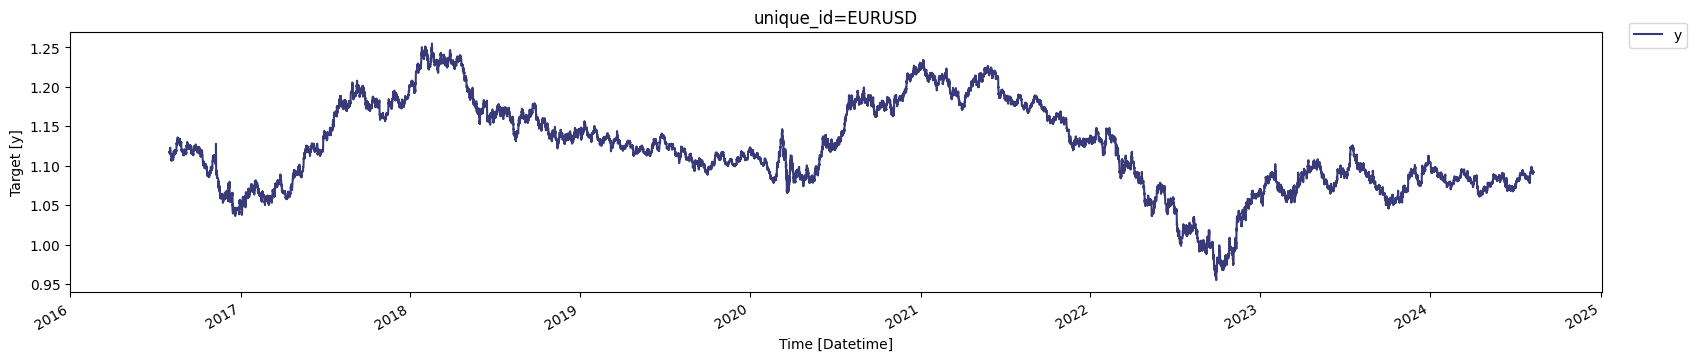

In [13]:
StatsForecast.plot(df_w_news_new_ds, time_col='Datetime')

In [14]:
# # Create a list of models and instantiation parameters
# models = [
#     AutoARIMA(),
#     HoltWinters(),
#     SeasonalNaive(season_length=7),
#     DOT(season_length=24),
#     AutoCES(),
#     AutoETS()
# ]
# # Instantiate StatsForecast class as sf
# sf = StatsForecast( 
#     models=models,
#     freq=1, 
#     n_jobs=-1,
#     fallback_model=SeasonalNaive(season_length=7),
#     verbose=True
# )


In [15]:
# forecasts_df = sf.forecast(df=df, h=48, level=[90])
# forecasts_df.head()


In [16]:
# # remove the 'HistoricAverage', 'HistoricAverage-lo-90', and 'HistoricAverage-hi-90'
# rm_cols = ['HistoricAverage', 'HistoricAverage-lo-90', 'HistoricAverage-hi-90']
# cols = [col for col in forecasts_df.columns if col not in rm_cols]
# forecasts_df_sel = forecasts_df.loc[:, cols]

In [17]:
# sf.plot(pd_df[(pd_df['ds'].dt.year >= 2024) & 
#               (pd_df['ds'].dt.month >= 8) & 
#               (pd_df['ds'].dt.day >= 8)], forecasts_df=forecasts_df_sel, models=['CrostonClassic', 'SeasonalNaive'], id_col='unique_id', time_col='ds', target_col='y')

# len(pd_df[(pd_df['ds'].dt.year >= 2024) & 
#               (pd_df['ds'].dt.month >= 1)])
# crossvaldation_df = sf.cross_validation(
#     df=df,
#     h=5,
#     step_size=5,
#     n_windows=3
# )
# crossvaldation_df

In [18]:
# def evaluate_cross_validation_polars(df, metric):
#     models = [c for c in df.columns if c not in ('unique_id', 'ds', 'cutoff', 'y')]
#     evals = []
#     # Calculate loss for every unique_id and cutoff.    
#     for cutoff in df['cutoff'].unique():
#         eval_ = evaluate(df.filter(pl.col('cutoff') == cutoff), metrics=[metric], models=models)
#         evals.append(eval_)
#     evals = pl.concat(evals).drop('metric')
#     # Calculate the mean of each 'unique_id' group
#     evals = evals.group_by(['unique_id'], maintain_order=True).mean() 

#     # For each row in evals (excluding 'unique_id'), find the model with the lowest value
#     best_model = [min(row, key=row.get) for row in evals.drop('unique_id').rows(named=True)]

#     # Add a 'best_model' column to evals dataframe with the best model for each 'unique_id'
#     evals = evals.with_columns(pl.Series(best_model).alias('best_model')).sort(by=['unique_id'])
#     return evals
# evaluation_df_polars = evaluate_cross_validation_polars(crossvaldation_df, rmse)
# evaluation_df_polars

# MLForecast

In [19]:
fcst = MLForecast(
    models=lgb.LGBMRegressor(n_jobs=1, random_state=0, verbosity=-1),
    freq=1,
    # lags=[24],    
    lag_transforms={
        1: [ExpandingMean()],
        1: [RollingMean(window_size=3), RollingMean(window_size=6)],
    },
    num_threads=2
)

In [4]:
df_w_news = (
    pl.scan_csv(f'EURUSD_full_tickstory_data_15_min_ready.csv')
    # convert 'Time' to datetime
    .with_columns([
        # add a unique_id col which will be 'EURUSD' as a string
        pl.lit('EURUSD').alias('unique_id').cast(pl.Utf8),
        pl.col('Time').alias('Datetime').str.to_datetime(format='%Y-%m-%d %H:%M:%S'),
        pl.arange(0, pl.len()).alias('ds'),
        # .dt.replace_time_zone('UTC'),
        # add a column that takes the sum of 'Open' 'High' 'Low' and 'Close' and divides it by 4
        pl.col('Close').alias('y')
    ])
    # .filter(pl.col('ds') >= pl.date(2023, 1, 1))
    # sort by 'Date'
   .sort('ds')
   .select(pl.col('unique_id', 'ds', 'y', 'seconds_since_last_news_event', 'seconds_to_next_news_event', 'Datetime'))
    ).collect()
df_w_news

unique_id,ds,y,seconds_since_last_news_event,seconds_to_next_news_event,Datetime
str,i64,f64,i64,i64,datetime[μs]
"""EURUSD""",0,1.11708,-14400,50400,2016-08-01 03:00:00
"""EURUSD""",1,1.11727,-15300,49500,2016-08-01 03:15:00
"""EURUSD""",2,1.11711,-16200,48600,2016-08-01 03:30:00
"""EURUSD""",3,1.11734,-17100,47700,2016-08-01 03:45:00
"""EURUSD""",4,1.11747,-18000,46800,2016-08-01 04:00:00
…,…,…,…,…,…
"""EURUSD""",200332,1.09185,-297900,146700,2024-08-09 22:45:00
"""EURUSD""",200333,1.09179,-298800,145800,2024-08-09 23:00:00
"""EURUSD""",200334,1.09172,-299700,144900,2024-08-09 23:15:00


In [5]:

# df_processed = fcst.preprocess(df_w_news, static_features=[])
max_date_1hr = df_w_news.select(pl.col('Datetime').max()).item()
testing = True
if testing:
    train, validation, test = fx_rl.slices_finder_polars(df_w_news, max_date_1hr, date_col='Datetime', testing_needed=testing)
    train = train.select(*df_w_news.columns).drop("Datetime")
    validation = validation.drop("Datetime")
    test = test.drop("Datetime")
    train_w_dt, validation_w_dt, test_w_dt = fx_rl.slices_finder_polars(df_w_news, max_date_1hr, date_col='Datetime', testing_needed=testing)
else:
    train, validation = fx_rl.slices_finder_polars(df_w_news, max_date_1hr, date_col='Datetime', testing_needed=testing)
    train = train.select(*df_w_news.columns).drop("Datetime")
    validation = validation.drop("Datetime")
    train_w_dt, validation_w_dt = fx_rl.slices_finder_polars(df_w_news, max_date_1hr, date_col='Datetime', testing_needed=testing)
train

unique_id,ds,y,seconds_since_last_news_event,seconds_to_next_news_event
str,i64,f64,i64,i64
"""EURUSD""",0,1.11708,-14400,50400
"""EURUSD""",1,1.11727,-15300,49500
"""EURUSD""",2,1.11711,-16200,48600
"""EURUSD""",3,1.11734,-17100,47700
"""EURUSD""",4,1.11747,-18000,46800
…,…,…,…,…
"""EURUSD""",199372,1.08572,-26100,134100
"""EURUSD""",199373,1.08569,-27000,133200
"""EURUSD""",199374,1.08565,-27900,132300


In [21]:
fcst.fit(train, static_features=[])
fcst.predict(h=1, X_df=validation.select(*train.columns))

unique_id,ds,LGBMRegressor
str,i64,f64
"""EURUSD""",49846,1.085846


In [22]:
cv_df = fcst.cross_validation(
    df=train,
    h=1,
    n_windows=100,
    static_features=[]
)
cv_df

unique_id,ds,cutoff,y,LGBMRegressor
str,i64,i64,f64,f64
"""EURUSD""",49746,49745,1.08887,1.088207
"""EURUSD""",49747,49746,1.08894,1.088226
"""EURUSD""",49748,49747,1.0888,1.088663
"""EURUSD""",49749,49748,1.0889,1.088682
"""EURUSD""",49750,49749,1.089,1.088599
…,…,…,…,…
"""EURUSD""",49841,49840,1.08616,1.085806
"""EURUSD""",49842,49841,1.08623,1.085854
"""EURUSD""",49843,49842,1.08592,1.085842


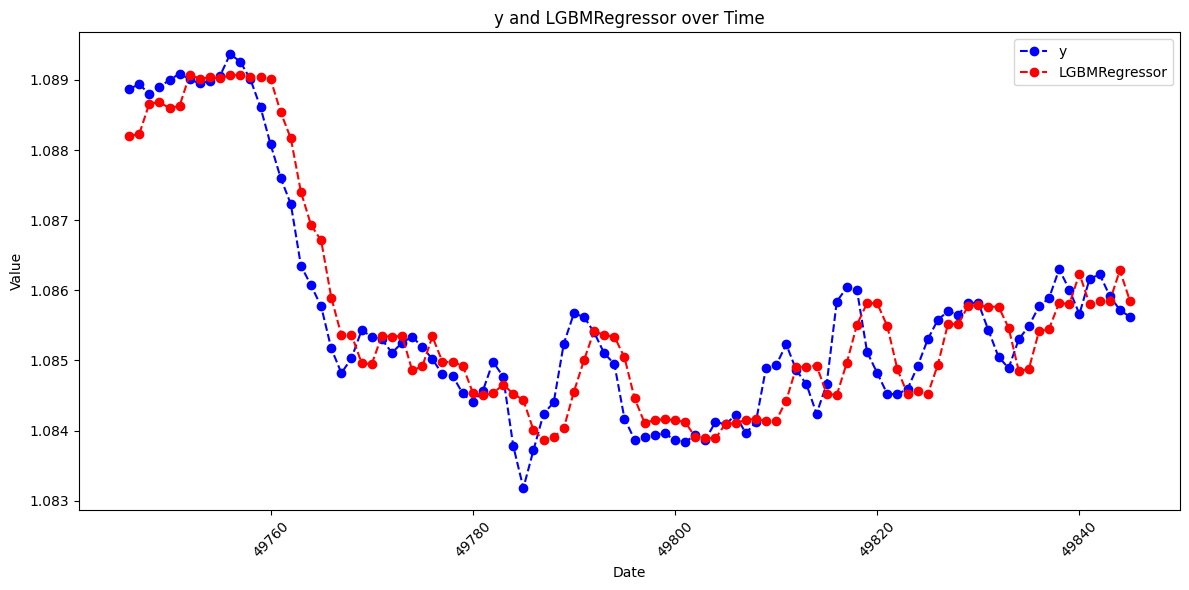

In [23]:
# plot the y and LGBMRegressor predictions on the y-axis, and have the x-axis be 'ds' 
# Assuming you have already created the cv_df DataFrame
# If not, you'll need to load or create it first

# Convert 'ds' column to datetime if it's not already
# cv_df = cv_df.with_columns(pl.col('ds').cast(pl.Datetime))

# Sort the DataFrame by 'ds' to ensure proper plotting
cv_df = cv_df.sort('ds')

# Convert Polars DataFrame to Pandas for easier plotting
pandas_df = cv_df.to_pandas()

# Create the plot
plt.figure(figsize=(12, 6))
# specify the line to be '-' and the points to be 'o'
plt.plot(pandas_df['ds'], pandas_df['y'], label='y', color='blue', linestyle='--', marker='o')
plt.plot(pandas_df['ds'], pandas_df['LGBMRegressor'], label='LGBMRegressor', color='red', linestyle='--', marker='o')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('y and LGBMRegressor over Time')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()


In [24]:

cv_rmse = evaluate(
    cv_df.drop('cutoff'),
    metrics=[rmse],
    agg_fn='mean',
)
print(f"RMSE using cross-validation: {cv_rmse['LGBMRegressor'].item()}")


RMSE using cross-validation: 0.000539656357704938


In [25]:
# 
# lgb_params = {
#     'verbosity': -1,
#     'num_leaves': 512,
# }

# lgbm_fcst = MLForecast(
#     models={
#         'avg': lgb.LGBMRegressor(**lgb_params),
#         'q75': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.75),
#         'q25': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.25),
#     },
#     freq=1, 
#     lags=[1, 24],
#     lag_transforms={
#         1: [ExpandingMean()],
#         24: [RollingMean(window_size=3), RollingMean(window_size=6)],
#     },
    
# )
# lgbm_fcst.fit(train, static_features=[])
# preds = lgbm_fcst.predict(10, X_df=validation)
# fig = plot_series(train, preds, max_insample_length=48)
# fig

# Auto ML

In [26]:
%pip install xgboost
# 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from mlforecast.auto import (
    AutoRandomForest,
    AutoElasticNet,
    AutoLasso,
    AutoLinearRegression,
    AutoXGBoost,
    AutoCatboost,
    AutoLightGBM
)
running_model = {'Catboost': AutoCatboost()}
auto_mlf = AutoMLForecast(
    models=running_model,
            # 'RandomForest': AutoRandomForest(), 'ElasticNet': AutoElasticNet(),
            # 'Lasso': AutoLasso(), 'LinearRegression': AutoLinearRegression(), 
            # 'Catboost': AutoCatboost(), 'XGBoost': AutoXGBoost(),
            # 'lgb': AutoLightGBM(), 'ridge': AutoRidge()},
    freq=1,
    season_length=24*4,
    fit_config=lambda trial: {'static_features': []}
)
auto_mlf.fit(
    pl.concat([train, validation.select(*train.columns)]).to_pandas(),
    n_windows=len(validation),
    h=1,
    num_samples=50,  # number of trials to run
    refit=True
)
auto_mlf.save('best_models2/')


In [6]:
model = MLForecast.load(f'best_models2/{list(running_model.keys())[0]}')
print(model)

NameError: name 'running_model' is not defined

In [7]:
from datetime import datetime, time
def is_on_hour(dt):
    return dt.time() == time(dt.hour, 0, 0)

def get_hourly_data(df):
    # sample df on Datetime column for hourly and take only the values in the row that is on the hour
    df_pd = df.to_pandas()
    # Define a function to check if a time is on the hour
    

    # Filter the DataFrame to keep only rows where the time is on the hour
    df_pd_hourly = df_pd[df_pd['Datetime'].apply(is_on_hour)]

    # Display the result
    return df_pd_hourly
validation_hr = get_hourly_data(validation_w_dt)
test_hr_pl = pl.from_pandas(get_hourly_data(test_w_dt))

In [8]:
model_1 = MLForecast.load(f'best_models2/LinearRegression')
model_1_auto_cv_df = model_1.cross_validation(
    df=pl.concat([train, validation.select(*train.columns), test.select(*train.columns)]),
    h=1,
    n_windows=len(test),
    static_features=[]
)
# model_1_auto_cv_df


In [9]:
model_2 = MLForecast.load(f'best_models2/Ridge')
model_2_auto_cv_df = model_2.cross_validation(
    df=pl.concat([train, validation.select(*train.columns), test.select(*train.columns)]),
    h=1,
    n_windows=len(test),
    static_features=[]
)
model_2_auto_cv_df

unique_id,ds,cutoff,y,ridge
str,i64,i64,f64,f64
"""EURUSD""",199857,199856,1.09209,1.091086
"""EURUSD""",199858,199857,1.09206,1.092482
"""EURUSD""",199859,199858,1.09205,1.092088
"""EURUSD""",199860,199859,1.09202,1.092049
"""EURUSD""",199861,199860,1.09157,1.092009
…,…,…,…,…
"""EURUSD""",200332,200331,1.09185,1.091816
"""EURUSD""",200333,200332,1.09179,1.091846
"""EURUSD""",200334,200333,1.09172,1.091767


In [12]:
model_2_auto_cv_df.write_csv('crossvalidation_df_LR.csv')

In [11]:
test_hr_merged_1 = test_hr_pl.select('unique_id', 'ds', 'y').join(model_1_auto_cv_df.select('ds', 'LinearRegression'), on='ds', how='left')
test_hr_merged_2 = test_hr_pl.select('unique_id', 'ds', 'y').join(model_2_auto_cv_df.select('ds', 'ridge'), on='ds', how='left')
cv_hrly_rmse_1 = evaluate(
    test_hr_merged_1,
    metrics=[rmse],
    agg_fn='mean',
)
cv_hrly_rmse_2 = evaluate(
    test_hr_merged_2,
    metrics=[rmse],
    agg_fn='mean',
)
cv_hrly_rmse_1.item(0, 'LinearRegression') - cv_hrly_rmse_2.item(0, 'ridge')

-2.7528803673475613e-08

In [ ]:
cv_hrly_rmse_1

In [82]:
rwd_cv = pl.read_csv('crossvalidation_df_RWD.csv')
rwd_cv.head()

test_hr_merged = test_hr_pl.select('unique_id', 'ds', 'y').join(rwd_cv.select('ds', 'RWD'), on='ds', how='left')
cv_hrly_rmse_rwd = evaluate(
    test_hr_merged,
    metrics=[rmse],
    agg_fn='mean',
)
cv_hrly_rmse_rwd.item(0, 'RWD')

0.0003766546610181

In [83]:
cv_hrly_rmse_rwd.item(0, 'RWD') - cv_hrly_rmse.item(0, list(running_model.keys())[0])

-7.885397788361505e-08

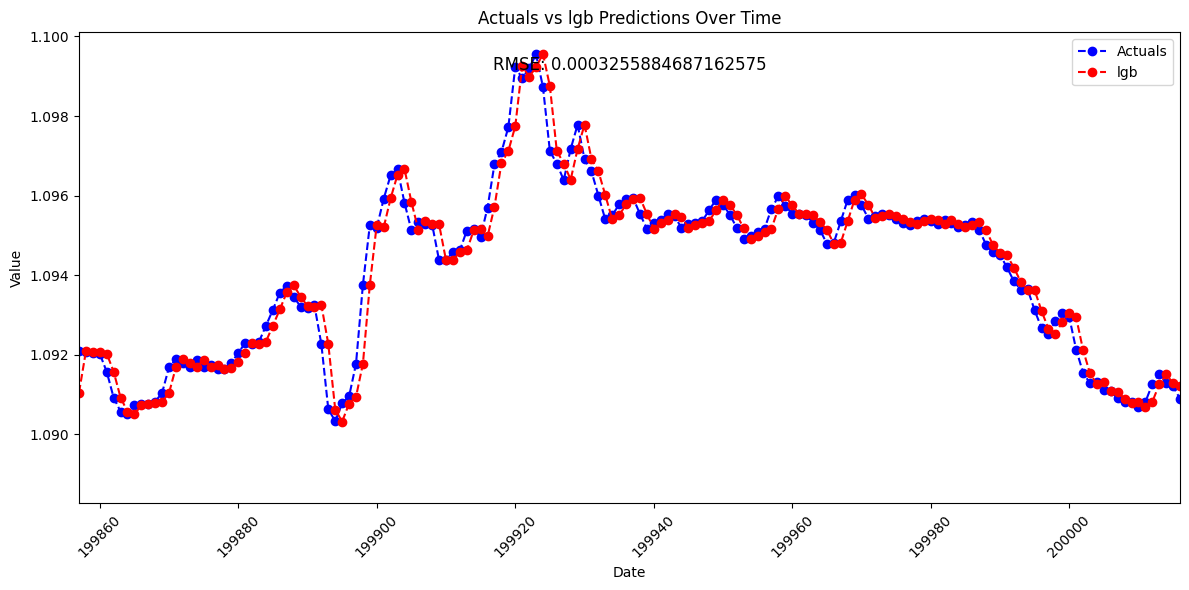

In [19]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse
def cv_plot(cv_df_to_plot, name):# Sort the DataFrame by 'ds' to ensure proper plotting
    cv_df_to_plot = cv_df_to_plot.sort('ds')

    # Convert Polars DataFrame to Pandas for easier plotting
    auto_cv_pd = cv_df_to_plot.to_pandas()

    # Create the plot
    plt.figure(figsize=(12, 6))
    # specify the line to be '-' and the points to be 'o'
    plt.plot(auto_cv_pd['ds'], auto_cv_pd['y'], label='Actuals', color='blue', linestyle='--', marker='o')
    plt.plot(auto_cv_pd['ds'], auto_cv_pd[name], label=name, color='red', linestyle='--', marker='o')


    cv_rmse = evaluate(
        auto_cv_pd.drop(columns={'cutoff'}),
        metrics=[rmse],
        agg_fn='mean',
    )
    # Display the RMSE value on the plot
    plt.text(0.5, 0.95, f'RMSE: {cv_rmse[name][0]}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center')

    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.xlim(auto_cv_pd['ds'].min(), auto_cv_pd['ds'].max() - 320)
    plt.title(f'Actuals vs {name} Predictions Over Time')
    plt.legend()

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # Show the plot
    plt.show()
cv_plot(lgb_auto_cv_df, 'lgb')

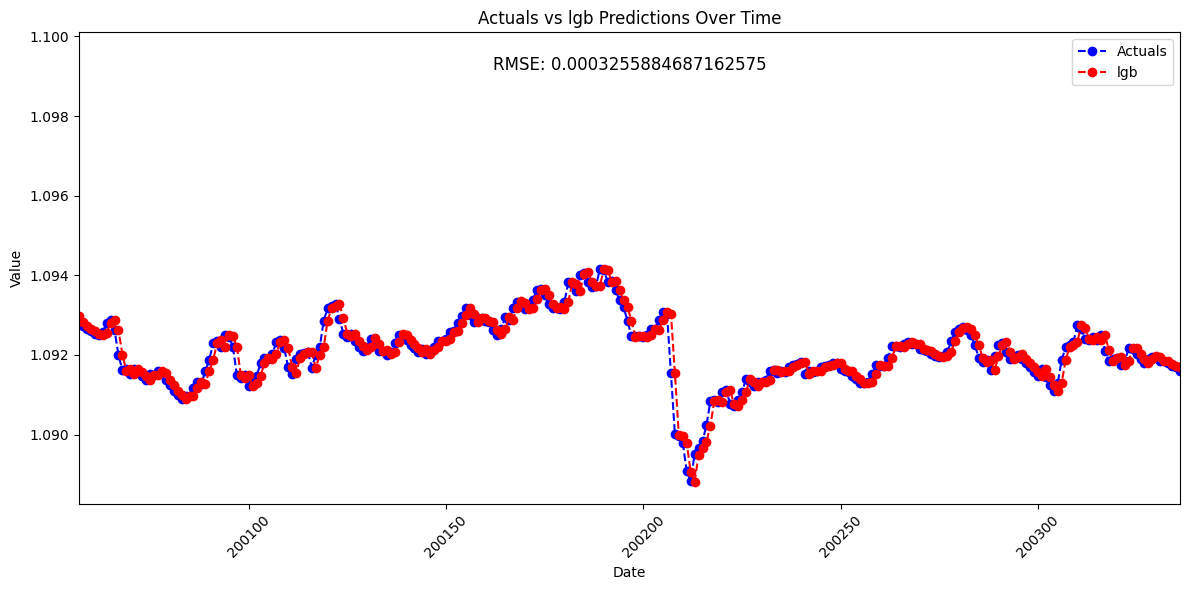

In [18]:
cv_plot(lgb_auto_cv_df, 'lgb')

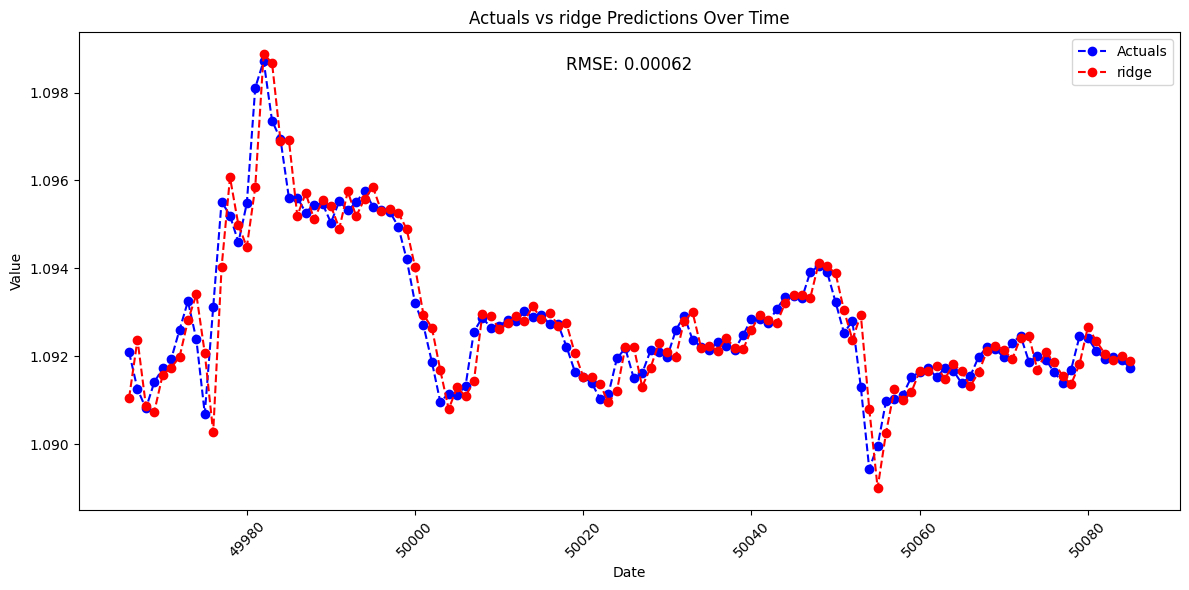

In [79]:
cv_plot(ridge_auto_cv_df, 'ridge')

In [101]:
auto_mlf.models_

{'lgb': MLForecast(models=[lgb], freq=1, lag_features=['lag24', 'exponentially_weighted_mean_lag1_alpha0.9', 'rolling_mean_lag24_window_size24_min_samples1'], date_features=[], num_threads=1),
 'ridge': MLForecast(models=[ridge], freq=1, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17', 'lag18', 'lag19', 'lag20', 'lag21', 'lag22', 'lag23', 'lag24', 'exponentially_weighted_mean_lag1_alpha0.9'], date_features=[], num_threads=1)}

In [91]:
auto_mlf.results_['ridge'].best_trial.user_attrs['config']

{'model_params': {'fit_intercept': True, 'alpha': 1.0747136333478982},
 'mlf_init_params': {'lags': range(1, 25),
  'target_transforms': [<mlforecast.target_transforms.LocalStandardScaler at 0x1d99fd5c610>],
  'lag_transforms': {1: [ExponentiallyWeightedMean(alpha=0.9)]},
  'date_features': None,
  'num_threads': 1},
 'mlf_fit_params': {'static_features': []}}

In [87]:
auto_mlf.models_['lgb'].save("lgb")

AttributeError: 'MLForecast' object has no attribute 'models_'

In [94]:
with tempfile.TemporaryDirectory() as tmpdir:
    auto_mlf.save(tmpdir)
    print(os.listdir(tmpdir))


AttributeError: 'MLForecast' object has no attribute 'models_'

In [48]:
tmpdir

'C:\\Users\\WILLIA~1\\AppData\\Local\\Temp\\tmpp51z3f71'

In [100]:
with tempfile.TemporaryDirectory() as tmpdir:
    # auto_mlf.save(tmpdir)
    loaded = MLForecast.load(f'{tmpdir}/lgb')
    print(loaded)


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/WILLIA~1/AppData/Local/Temp/tmpaox5fdvq/lgb/ts.pkl'